# Importing and Installing libraries

In [1]:
# Install required libs

### please update Albumentations to version>=0.3.0 for `Lambda` transform support
!pip install -U albumentations>=0.3.0 --user 
!pip install -U --pre segmentation-models --user
#This installation command is to resolve issues with respect to efficient not being found in the initila build of segmentation modle sm 
!pip install -U git+https://github.com/qubvel/segmentation_models
#uPGRADE SCKITI IMAGE
!pip install --upgrade scikit-image
#RESTART THE KERNEL POST INSTALLATION
#This is to resolve the dependency issues with skimage. 
!pip install numpy==1.17
!pip install ipdb

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Requirement already up-to-date: segmentation-models in /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages (1.0.0)
Requirement not upgraded as not directly required: keras-applications<=1.0.8,>=1.0.7 in /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages (from segmentation-models) (1.0.8)
Requirement not upgraded as not directly required: image-classifiers==1.0.0 in /home/ec2-user/.local/lib/python3.6/site-packages (from segmentation-models) (1.0.0)
Requirement not upgraded as not directly required: efficientnet==1.0.0 in /home/ec2-user/.local/lib/python3.6/site-packages (from segmentation-models) (1.0.0)
Requirement not upgraded as not directly required: h5py in /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages (from keras-applications<=1.0.8,>=1.0.7->segmentation-models) (2.8.

  Running setup.py bdist_wheel for segmentation-models ... done
  Stored in directory: /tmp/pip-ephem-wheel-cache-794i419q/wheels/49/cf/46/cbb4bb64518c402aea99df9d466f1081450597e653256bbcf4
Successfully built segmentation-models
  Found existing installation: segmentation-models 1.0.0
    Uninstalling segmentation-models-1.0.0:
      Successfully uninstalled segmentation-models-1.0.0
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Requirement already up-to-date: scikit-image in /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages (0.16.2)
Requirement not upgraded as not directly required: scipy>=0.19.0 in /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages (from scikit-image) (1.3.0)
Requirement not upgraded as not directly required: matplotlib!=3.0.0,>=2.0.0 in /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages (from scikit-im

In [2]:
#RESTART THE KERNEL POST INSTALLATION of cell above

import os

#Confirmation that GPU is in working order. 
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import tensorflow as tf
from sklearn.model_selection import train_test_split
import glob
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
import imageio
import albumentations as A
import random
import segmentation_models as sm
import datetime
import itertools
from sklearn.utils import class_weight
import imageio
import numpy as np
import pickle
import ipdb
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'
from keras.models import load_model

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ec2-user/a

Segmentation Models: using `keras` framework.


In [3]:


print(tf.test.gpu_device_name())

with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.Session() as sess:
    print (sess.run(c))

/device:GPU:0
[[22. 28.]
 [49. 64.]]


# Loading data for analysis

In [4]:
test_data_dir=r'/home/ec2-user/SageMaker/data/test/NIFTI_MR_256x256_png_256grey_lvl/t1dual_inphase'
x_test_dir = os.path.join(test_data_dir, 'images')
y_test_dir = os.path.join(test_data_dir, 'masks')

# Loading function calls for analysis

## Data loader and dataset functions

In [5]:
# helper function for data visualization
def visualize(fig_nm=None,figdim=(30,30),**images):
    """PLot images in one row."""
    n = len(images)
    print(fig_nm)
    plt.figure(figsize=figdim)
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    
    if fig_nm is not None:
        plt.savefig(fig_nm)
    else:
        plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = {'background':0,'liver':63,'r_kidney':126,'l_kidney':189,'spleen':252}
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
            ret_img_path=False,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES[cls.lower()] for cls in classes]
        self.ret_img_path=ret_img_path
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = imageio.imread(self.images_fps[i])#cv2.imread(self.images_fps[i])
        image_nm=os.path.basename(self.images_fps[i])
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image=np.expand_dims(image,axis=2)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        if self.ret_img_path==True:
            return image, mask,image_nm
        else:
            return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   
            
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation(dim_sp=256):
    
    rand_int_alpha=random.uniform(0,3)
    if rand_int_alpha<=0.5:
        rand_int_sigma=random.uniform(0.1,rand_int_alpha)
    elif rand_int_alpha>=2:
        rand_int_sigma=random.uniform(rand_int_alpha/1.8,rand_int_alpha)
    else:
        rand_int_sigma=random.uniform(rand_int_alpha/1.8,rand_int_alpha)
    train_transform = [
        #A.RandomGridShuffle(p=0.4,grid=(8, 8)),
        A.ElasticTransform(p=0.9,alpha=rand_int_alpha,sigma=rand_int_sigma,border_mode=cv2.BORDER_REPLICATE), #,alpha_affine=20
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        #A.RandomSizedCrop(p=0.5),
        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=90, shift_limit=0.1, p=0.5, border_mode=cv2.BORDER_REPLICATE),

        #A.PadIfNeeded(min_height=dim_sp, min_width=dim_sp, always_apply=True, border_mode=cv2.BORDER_REPLICATE),
        #A.RandomCrop(height=dim_sp, width=dim_sp, always_apply=True),

        A.OneOf(
            [
                A.IAASharpen(p=0.5),
                A.Blur(blur_limit=3, p=0.5)
            ],
            p=0.2,
        ),

        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)

def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(256, 256)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

In [6]:
def gen_subdir_file_lst(dir_nm:str,file_sub_str:str):
    """The purpose of this method is to generate a file list for """

    final_list=[]
    for root,subdir,files in os.walk(dir_nm):
        if len(files)>0:

            file_list=glob.glob(root+file_sub_str)
            final_list=final_list+file_list
    #Sorted to ensure history part 2,3 etc are synced together 
    return sorted(final_list)

In [7]:
def get_file_info(file,add_info):
    """The purpose of this method is to pull file information from the file name presnet in the string"""
    split_vals=file.split('_')
    split_vals.sort()
    file_dict={}
    #Iterate through additional information of set of tuples on file strings for analysis
    for param_k,param_v in add_info:

        file_dict[param_k]=[x for x in param_v if x in split_vals][0]
    return file_dict,split_vals

In [8]:
def gen_test_dataset(test_data_dir,model_gnrl_params,preprocess_input,ret_img_path_var):
    
    x_test_dir=os.path.join(test_data_dir,'images')
    y_test_dir=os.path.join(test_data_dir,'masks')
    
    return Dataset(x_test_dir, y_test_dir, 
                            classes=model_gnrl_params['classes'],
                           augmentation=get_validation_augmentation(),
                           preprocessing=get_preprocessing(preprocess_input),ret_img_path=ret_img_path_var,)

## Generate model and test model functions

In [9]:
def gen_test_model(model_gnrl_param:dict,optim,total_loss,wghts_dir:str):
    """The purpose of this method is to generate a test model from the directory for analysis"""

    reload_model = sm.Unet(model_gnrl_param['backbone'], classes=model_gnrl_param['n_classes'],
                           activation=model_gnrl_param['activation_type'],
                           encoder_weights=None,
                           input_shape=(None, None,model_gnrl_param['input_shape_N']))
    
    reload_model.compile(optim, total_loss,model_gnrl_param['metrics'])

    reload_model.load_weights(wghts_dir)
    
    return reload_model

In [10]:
def gen_test_scores(model,test_dataloader,metrics)->dict:
    """The purpose of this method is to generate a summary dictionary
    of a model test set metrics for analysis"""
    
    metric_dict={}
    
    scores = model.evaluate_generator(test_dataloader)

    metric_dict["loss"]=scores[0]
    for metric, value in zip(metrics, scores[1:]):
        metric_dict[metric.__name__]=value
        
    return metric_dict

In [11]:
def gen_test_images(tmp_model,test_dataset,file_dict:dict,model_dir):
    """Generate testing images for analysis"""
    loss_func=file_dict['loss_type']
    lrn_rate=file_dict['learn_rate']
    dst_dir=os.path.join(model_dir,'predict_imgs',loss_func+'_lr_'+lrn_rate)
    #Making a directory based on initial analysis
    if os.path.isdir(dst_dir)==True:
        pass
    else:
        os.mkdir(dst_dir)
    
    num_files=len(test_dataset)
    
    for i in range(0,num_files):
        #Generating image dataset and mask 
        image,gt_mask,img_nm=test_dataset[i]
        dst_img_path=os.path.join(dst_dir,'predict_'+img_nm)
        #Getting images setup for testing
        image = np.expand_dims(image, axis=0)
        #Squeezing predicted images down to pass testing. 
        pr_mask = tmp_model.predict(image)
        pr_mask_sqz=pr_mask.squeeze()
        #Writing line of predicted images to file for analysis and verification. 
        visualize(dst_img_path,
            image=denormalize(image.squeeze()),
            gt_mask_l_kidney=gt_mask[:,:,0],
            pr_mask_l_kidney=pr_mask_sqz[:,:,0],
            gt_mask_liver=gt_mask[:,:,1],
            pr_mask_liver=pr_mask_sqz[:,:,1],
            gt_mask_r_kidney=gt_mask[:,:,2],
            pr_mask_r_kidney=pr_mask_sqz[:,:,2],
            gt_mask_spleen=gt_mask[:,:,3],
            pr_mask_spleen=pr_mask_sqz[:,:,3],
            gt_mask_background=gt_mask[:,:,4],
            pr_mask_background=pr_mask_sqz[:,:,4],
        )    

In [12]:
def get_test_set_df(model_dir,test_data_dir,
                    model_gnrl_param_dict,loss_funcs_dict,add_info,mode='Test'):
    """The purpose of this method is to generate a """
    #Generating assertion 
    assert mode.lower() in ['test','visualize'],'incorrect mode selection'
    #Generating list of paths to models weights for analysis
    model_weights_dir=gen_subdir_file_lst(model_dir,'/*.h5')
    #Generating dataset for analysis
    preprocess_input = sm.get_preprocessing(model_gnrl_param_dict['backbone'])
    
    if mode.lower()=='visualize':
        ret_img_path_var=True
    else:
        ret_img_path_var=False
        
    test_dataset=gen_test_dataset(test_data_dir,model_gnrl_params,preprocess_input,ret_img_path_var)
    test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)
    #Final json list to return for analysis
    final_lst=[]
    for fl_path in model_weights_dir:
        #File path dictionayr information for analysis
        file_dict,split_vals=get_file_info(fl_path,add_info)
        #ipdb.set_trace()
        #Generating specific parameters for laoding the model based on file name
        lrn_rate=float(file_dict['learn_rate'])
        loss_type=file_dict['loss_type']
        loss=loss_funcs_dict[loss_type]
        optimiser=keras.optimizers.Adam(lrn_rate)
        
        #Load temporary model for analysis
        tmp_model=gen_test_model(model_gnrl_param_dict,
                                 optimiser,
                                 loss,fl_path)
        #Test model based on dataset and analysis
        if mode.lower()=='test':
            
            tmp_score_dict=gen_test_scores(tmp_model,test_dataloader,model_gnrl_params['metrics'])
            file_dict.update(tmp_score_dict)
            final_lst.append(file_dict)
        else:
            #ipdb.set_trace()
            gen_test_images(tmp_model,test_dataset,file_dict,model_dir)
    
    return final_lst
      

# Load initial parameters for analysis

In [13]:
#Loading arguments for analysis
#'efficientnetb3'densenet121
#BATCH_SIZE = 3
CLASSES = ['l_kidney','liver','r_kidney','spleen']


activation = 'sigmoid' if len(CLASSES) == 1 else 'softmax'
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

cls_wghts_perc=np.array([0.03987201, 0.36867433, 0.35872208, 0.2314718 , 0.00125978])
#Getting keys for different analysis types
add_info=[('learn_rate',['0.0003','0.001','0.01','0.1']),
          ('samp_sz',['250']),('btch_sz',['3','7']),
          ('loss_type',['dice','focal','cat'])]

loss_func={'cat':sm.losses.CategoricalCELoss(class_weights=cls_wghts_perc),
           'focal':sm.losses.CategoricalFocalLoss(),
           'dice':sm.losses.DiceLoss(class_weights=cls_wghts_perc)}

model_gnrl_params={'backbone':'resnet101','n_classes':len(CLASSES)+1,
                   'metrics':metrics,'input_shape_N':1,
                   'activation_type':activation,'classes':['l_kidney','liver','r_kidney','spleen']}
#Generating weights directory for iterating for analysis
#Directory lists 
model_dir=r'/home/ec2-user/SageMaker/model_files'                    
test_data_dir=r'/home/ec2-user/SageMaker/data/250_imgs/test/NIFTI_MR_256x256_png_256grey_lvl/t1dual_inphase'

In [14]:
os.mkdir('/home/ec2-user/SageMaker/model_files/predict_imgs/cat_0.003/')

In [22]:
model_results=get_test_set_df(model_dir,test_data_dir,
                              model_gnrl_params,loss_func,add_info)

/home/ec2-user/.local/lib/python3.6/site-packages/albumentations/augmentations/transforms.py:2875: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  "Using lambda is incompatible with multiprocessing. "


In [24]:
import pandas as pd

In [26]:
model_df=pd.DataFrame.from_dict(model_results)
model_df.to_csv('unet_model_test_data_summary_results_05_11_2019.csv')

In [30]:
model_df.sort_values('f1-score',ascending=False)

,btch_sz,f1-score,iou_score,learn_rate,loss,loss_type,samp_sz
16,3,0.697137,0.664423,0.001,0.016060,focal,250
15,3,0.668877,0.641736,0.0003,0.021826,focal,250
18,3,0.630676,0.611101,0.1,0.024256,focal,250
17,3,0.628789,0.600515,0.01,0.020441,focal,250
7,7,0.554375,0.510995,0.1,0.001331,cat,250
11,3,0.529640,0.525482,0.1,0.927148,dice,250
13,7,0.517893,0.472351,0.001,0.936010,dice,250
9,3,0.475711,0.419127,0.001,0.937979,dice,250
0,3,0.455430,0.393119,0.0003,0.000659,cat,250
5,7,0.446474,0.388626,0.001,0.000731,cat,250


# Visualisation of results

In [ ]:
fl_path=r'/home/ec2-user/SageMaker/model_files/focal_loss_bckgrnd_in_loss/btch_sz_3/models/t1dual_inphase_all_orgs_grey_lvl_256_optm_adam_loss_focal_loss_all_cls_idx_trn_samp_sz_250_btch_sz_3_lr_0.0003_time_2019-10-26.h5'
optimiser=keras.optimizers.Adam(0.003)
loss=loss_func['focal']
preprocess_input = sm.get_preprocessing(model_gnrl_params['backbone'])

tmp_model=gen_test_model(model_gnrl_params,
                                 optimiser,
                                 loss,fl_path)

test_dataset_visualise=gen_test_dataset(test_data_dir,model_gnrl_params,preprocess_input,)

In [ ]:
model_results=get_test_set_df(model_dir,test_data_dir,
                              model_gnrl_params,loss_func,add_info,mode='visualize')

In [46]:
file_path=r'/home/ec2-user/SageMaker/data/test/NIFTI_MR_256x256_png_256grey_lvl/t1dual_inphase/images'
img_dim=[]
for files in glob.glob(file_path+'/*.png'):
    
    trl_img=imageio.imread(files)
    img_dim.append(trl_img.shape[0])

37


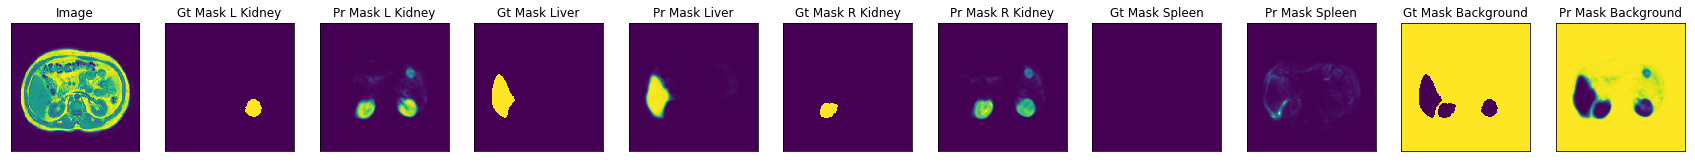

75


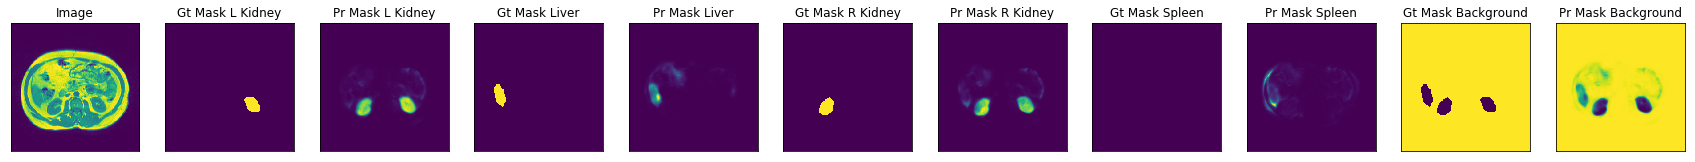

16


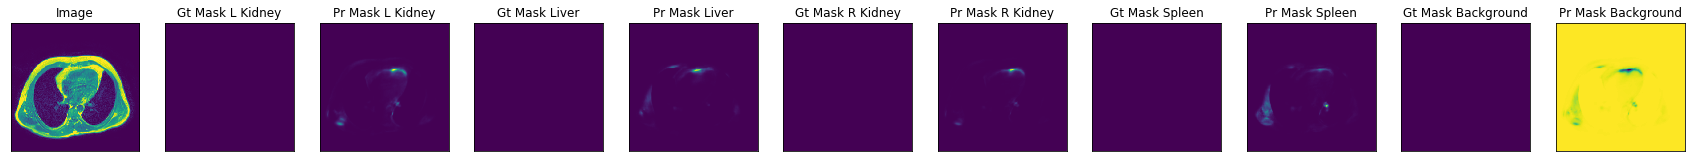

18


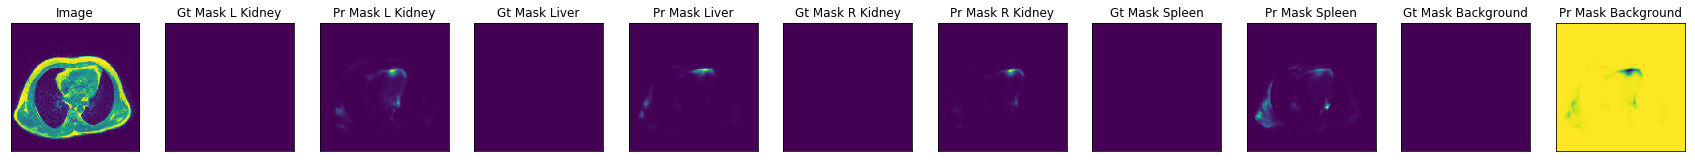

8


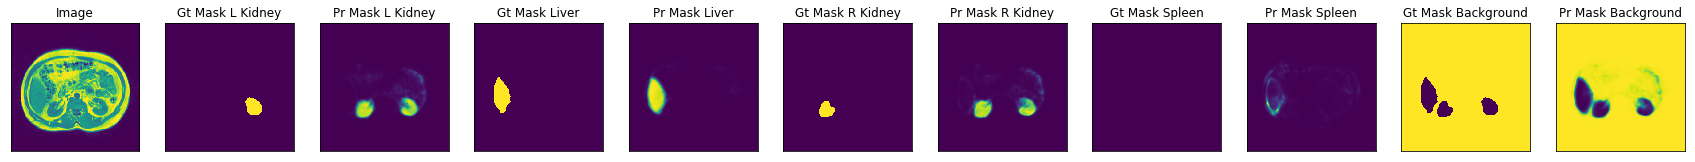

In [58]:



n = 5
import random
random.seed(15)
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    print(i)
    image, gt_mask,img_nm = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = tmp_model.predict(image)
    pr_mask_sqz=pr_mask.squeeze()
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask_l_kidney=gt_mask[:,:,0],
        pr_mask_l_kidney=pr_mask_sqz[:,:,0],
        gt_mask_liver=gt_mask[:,:,1],
        pr_mask_liver=pr_mask_sqz[:,:,1],
        gt_mask_r_kidney=gt_mask[:,:,2],
        pr_mask_r_kidney=pr_mask_sqz[:,:,2],
        gt_mask_spleen=gt_mask[:,:,3],
        pr_mask_spleen=pr_mask_sqz[:,:,3],
        gt_mask_background=gt_mask[:,:,4],
        pr_mask_background=pr_mask_sqz[:,:,4],
    )

In [36]:
pr_mask.squeeze().shape

(384, 480, 5)